In [ ]:
!pip install segment-anything

In [ ]:
!pip install wget

In [ ]:
import os
import cv2
import wget
import torch
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import matplotlib.patches as patches
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
drive_path = '/content/drive/MyDrive/sam_vit_h_4b8939.pth'
local_path = 'sam-weights/sam_vit_h_4b8939.pth'

# Create directory if it does not exist
os.makedirs(os.path.dirname(local_path), exist_ok=True)

# Copy the file from Google Drive to the local path
if not os.path.exists(local_path):
    !cp "$drive_path" "$local_path"
    print("-- weights copied from Google Drive --")
else:
    print("-- weights already exist locally --")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
-- weights already exist locally --


In [ ]:
def load_sam(model_type, sam_checkpoint, device):
  print ("Loading model...")
  sam = sam_model_registry[model_type] (checkpoint=sam_checkpoint)
  print(f"Shifting model to {device} device...")
  sam.to(device=device)
  return sam

In [ ]:
model_type = "vit_h"
sam_checkpoint ="sam-weights/sam_vit_h_4b8939.pth"
device = torch.device ("cuda" if torch.cuda.is_available() else "cpu")
sam = load_sam(model_type, sam_checkpoint, device)

Loading model...
Shifting model to cuda device...


In [ ]:
def load_image(image_path):
  image = Image.open(image_path).convert('RGB')
  return image

def resize_image(image, max_dimension=200):
  width, height = image.size
  if width > height:
    new_width= max_dimension
    new_height =int(height * (max_dimension / width) )
  else:
    new_height = max_dimension
    new_width = int(width * (max_dimension / height) )
  image = image.resize( (new_width, new_height), Image. LANCZOS)
  return image

In [ ]:
image_path="mall-floor-plan.png"

Processing image...


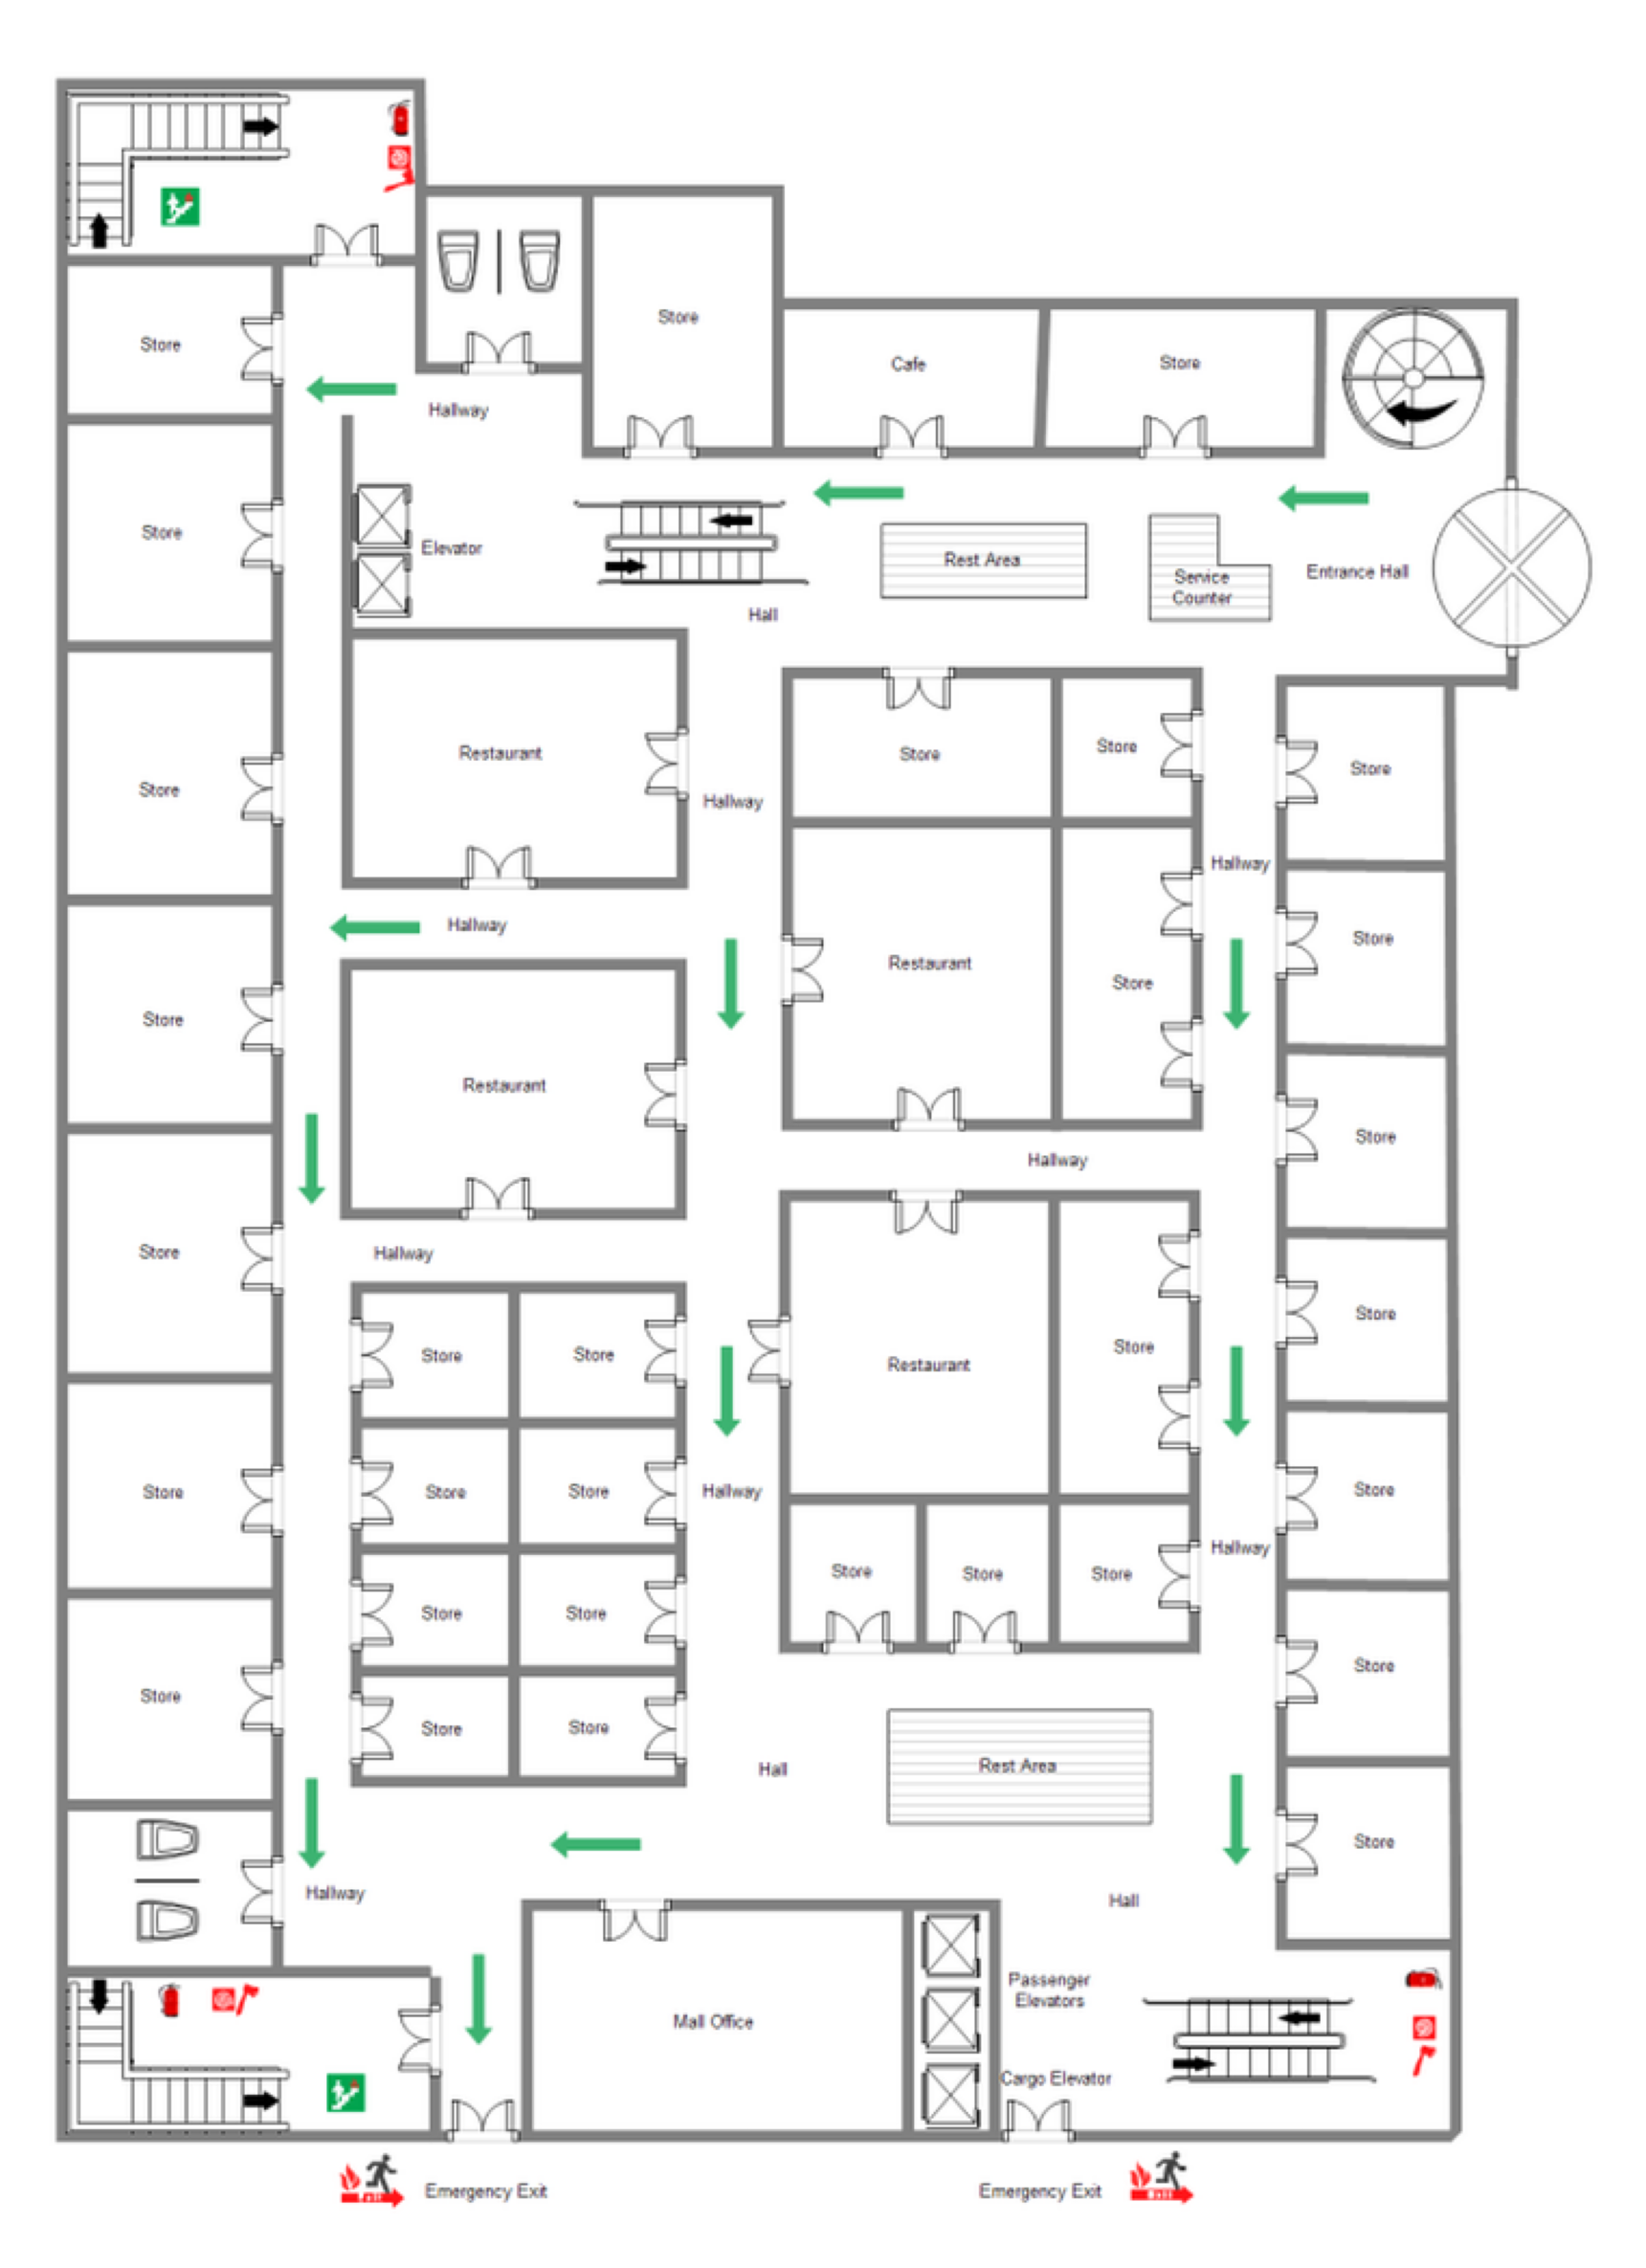

In [ ]:
print ("Processing image...")
image = load_image (image_path)
image =resize_image(image, max_dimension=1024) # resize to specific dimension
image = np.array (image) # convert to numpy array
# Display Image
plt.figure(figsize=(10,10), dpi=300)
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
def get_sam_masks(image, sam_model):
  print("Initiating SAM mask generator...")
  mask_generator = SamAutomaticMaskGenerator (
    model=sam_model,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1, #* mask prediction will be run again on crops of the image
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
  )
  print("Predicting masks...")
  masks = mask_generator.generate(image)
  return masks

In [ ]:
def show_anns(anns, save_path=None):
    if len(anns) == 0:
        return

    if 'area' in anns[0]:
        sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    else:
        sorted_anns = anns

    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))  # RGBA array

    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.351]])  # Random RGB color with alpha value
        img[m] = color_mask

    ax.imshow(img)
    plt.axis('off')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        print(f"Annotated image saved to {save_path}")
    plt.show()


In [ ]:
print ("Extracting SAM masks...")
masks = get_sam_masks (image,sam)
print ("Total segmentation masks:", len(masks))

Extracting SAM masks...
Initiating SAM mask generator...
Predicting masks...
Total segmentation masks: 189


In [ ]:
output_image_dir = "/content/downloads"
os.makedirs(output_image_dir, exist_ok=True)
output_image_path = os.path.join(output_image_dir, "annotated_image.png")

plt.figure(figsize=(10, 10), dpi=300)
plt.imshow(image)
show_anns(masks, save_path=output_image_path)
plt.axis('off')
plt.show()

print(f"Annotated image saved at: {output_image_path}")

In [ ]:
# Save and display each mask separately
for i, mask_info in enumerate(masks):
    mask_image = Image.fromarray(mask_info['segmentation'])

    # Save the mask
    mask_filename = f"mask_{i + 1}.png"
    mask_path = os.path.join(output_masks_dir, mask_filename)
    mask_image.save(mask_path)

    # Display the mask
    plt.figure(figsize=(5, 5))
    plt.imshow(mask_image, cmap='gray')
    plt.title(f"Mask {i + 1}")
    plt.axis('off')
    plt.show()

print(f"Masks saved at: {output_masks_dir}")
